# DS-SF-34 | Final Project | 3 | Summary
---

## Project Problem & Hypothesis

**What's the project about? What problem are you solving?**

Where are people traveling to more frequently based on user types. Specifically, those going to Las Vegas or Orlando. The assumption is older travelers will go to Las Vegas, while more families with young children will go to Orlando. These two locations were picked because they bring in the most revenue.

**Background**

I work at a company in the travel industry. Many of our clients are concerned about how to spend their marketing budget. Since we collect data on their travelers, we should be able to advise them on where certain groups of people visit more often.

**Other background information?**

The reason why Las Vegas and Orlando were selected is because they bring in the most revenue for this particular client. This project can then be elaborated in the future to provide more insights on different destinations and user groups. 

---

## Summary

**What were you trying to accomplish?**

This is a classification problem. I am trying to predict the top locations for a user group. The user group will be defined based on where country of purchase, origin airport, number of adults, children, seniors, or infants.

**What steps did your project take?**

---

## Data
**Source**

The data is from the company's data warehouse. The data is specifically for one client and users that purchased air-only travel. 

**Description**

**Attributes**
* custid: string, a unique identification for each customer
* entered_date: timestamp, the date when the flight booking was made
* travel_begin_date: date, the date when the travel begins (first flight)
* travel_end_date: date, the date when the travel ends (last flight)
* country_name: string, the country where the traveler booked the trip
* cancelled: boolean, whether or not the booking was cancelled
* cancelled_date: date, the date of when the booking was cancelled
* loyalty: boolean, whether or not the traveler used loyalty points to purchase the booking
* departure_airportcode: string, the airport where the first flight takes off
* destination_airportcode: string, the airport where the last flight takes off

**Metrics**
* package_price_in_points: integer, price of the flight in points
* air_total_in_system_currency: double, price of the flight in cash
* discount_total_in_system_currency: double, cost of the flight that was deducted due to promotions or discounts
* adults: integer, number of adults (18-64 years of age)that are part of the booking
* seniors: integer, number of seniors (65+ years of age) that are part of the booking
* children: integer, number of children (2-17 years of age) that are part of the booking
* infants_in_seat: integer, number of infants (0-2 years of age) that are part of the booking and seating in their own booked seat
* infants_in_lap: integer, number of infants (0-2 years of age) that are held during the flight and do not require their own booked seat


## Exploration of Data

In [1]:
import os

import math
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 20)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)

   # REGULAR EXPRESSIONS
import re  

   # PLOTTING
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

   # K NEAREST NEIGHBORS and LINEAR REGRESSION
from sklearn import preprocessing, linear_model, model_selection, metrics
from sklearn.model_selection import cross_val_score

   # STATS  
import scipy.stats as stats
import statsmodels.api as sm
   #smf.ols takes out NA values
import statsmodels.formula.api as smf  

from sklearn import feature_selection, linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor

In [2]:
df = pd.read_csv(os.path.join('..', '2', 'air_only_train.csv'))
df_test = pd.read_csv(os.path.join('..', '2', 'air_only_test.csv'))

In [3]:
df.sum()

custid                               2.212344e+10
loyalty                              1.989000e+03
package_price_in_points              3.105990e+07
air_total_in_system_currency         1.553650e+07
discount_total_in_system_currency    4.997433e+04
adults                               3.604300e+04
seniors                              0.000000e+00
children                             3.035000e+03
infants_in_seat                      1.500000e+01
infants_in_lap                       4.480000e+02
dtype: float64

In [4]:
df_test.sum()

custid                               2.054656e+09
loyalty                              9.300000e+01
package_price_in_points              6.518000e+05
air_total_in_system_currency         8.505539e+05
discount_total_in_system_currency    3.582410e+03
adults                               1.708000e+03
seniors                              0.000000e+00
children                             1.940000e+02
infants_in_seat                      0.000000e+00
infants_in_lap                       4.400000e+01
dtype: float64

Decided to remove the seniors field because it is an empty column.

In [5]:
df.drop('seniors', axis = 1, inplace = True)
df.drop('custid', axis = 1, inplace = True)

In [6]:
df['total_children'] = df.children + df.infants_in_seat + df.infants_in_lap
df['total_passengers'] = df.adults + df.total_children
df['booking_window'] = (pd.to_datetime(df.travel_begin_date)-pd.to_datetime(df.entered_date)).dt.days
df['Dest_LAS'] = np.where(df['destination_airportcode'] == 'LAS', 1,0)
df['Dest_MCO'] = np.where(df['destination_airportcode'] == 'MCO', 1,0)

In [7]:
df_mcoonly = df[df['destination_airportcode'] == 'MCO']
df_lasonly = df[df['destination_airportcode'] == 'LAS']

dest_frames = [df_mcoonly, df_lasonly]
df_mcolasonly = pd.concat(dest_frames)

#df_mcolasonly

In [8]:
df_test.drop('seniors', axis = 1, inplace = True)
df_test.drop('custid', axis = 1, inplace = True)
df_test['total_children'] = df_test.children + df_test.infants_in_seat + df_test.infants_in_lap
df_test['total_passengers'] = df_test.adults + df_test.total_children
df_test['booking_window'] = (pd.to_datetime(df_test.travel_begin_date)-pd.to_datetime(df_test.entered_date)).dt.days
df_test['Dest_LAS'] = np.where(df_test['destination_airportcode'] == 'LAS', 1,0)
df_test['Dest_MCO'] = np.where(df_test['destination_airportcode'] == 'MCO', 1,0)

In [9]:
df_test.describe().transpose()

count         mean           std    min  \
package_price_in_points            775.0   841.032258  10080.628132   0.00   
air_total_in_system_currency       775.0  1097.488877    917.745481  71.12   
discount_total_in_system_currency  775.0     4.622465     34.961356   0.00   
adults                             775.0     2.203871      1.180039   1.00   
children                           775.0     0.250323      0.587815   0.00   
infants_in_seat                    775.0     0.000000      0.000000   0.00   
infants_in_lap                     775.0     0.056774      0.237074   0.00   
total_children                     775.0     0.307097      0.694116   0.00   
total_passengers                   775.0     2.510968      1.442998   1.00   
booking_window                     775.0    60.378065     55.224421  -1.00   
Dest_LAS                           775.0     0.025806      0.158660   0.00   
Dest_MCO                           775.0     0.214194      0.410527   0.00   

                                      25%    50%     75%       max  
package_price_in_points              0.00    0.0     0.0  198000.0  
air_total_in_system_currency       557.85  820.8  1401.6    7468.5  
discount_total_in_system_currency    0.00    0.0     0.0     503.0  
adults                               1.00    2.0     3.0      10.0  
children                             0.00    0.0     0.0       4.0  
infants_in_seat                      0.00    0.0     0.0       0.0  
infants_in_lap                       0.00    0.0     0.0       2.0  
total_children                       0.00    0.0     0.0       4.0  
total_passengers                     2.00    2.0     3.0      10.0  
booking_window                      20.00   42.0    96.0     263.0  
Dest_LAS                             0.00    0.0     0.0       1.0  
Dest_MCO                             0.00    0.0     0.0       1.0

In [10]:
df_mcoonly_test = df_test[df_test['destination_airportcode'] == 'MCO']
df_lasonly_test = df_test[df_test['destination_airportcode'] == 'LAS']

dest_frames = [df_mcoonly_test, df_lasonly_test]
df_mcolasonly_test = pd.concat(dest_frames)

In [11]:
df.corr()

loyalty  package_price_in_points  \
loyalty                            1.000000                 0.508105   
package_price_in_points            0.508105                 1.000000   
air_total_in_system_currency      -0.095300                -0.060279   
discount_total_in_system_currency -0.002131                -0.039464   
adults                            -0.123659                -0.069598   
children                          -0.069011                -0.033547   
infants_in_seat                    0.003959                -0.007613   
infants_in_lap                    -0.031418                -0.023313   
total_children                    -0.071944                -0.037603   
total_passengers                  -0.134926                -0.075310   
booking_window                     0.032974                 0.052771   
Dest_LAS                           0.018044                -0.020177   
Dest_MCO                          -0.012800                 0.019443   

                                   air_total_in_system_currency  \
loyalty                                               -0.095300   
package_price_in_points                               -0.060279   
air_total_in_system_currency                           1.000000   
discount_total_in_system_currency                     -0.002055   
adults                                                 0.759540   
children                                               0.204175   
infants_in_seat                                        0.003972   
infants_in_lap                                         0.031230   
total_children                                         0.196943   
total_passengers                                       0.775390   
booking_window                                         0.189738   
Dest_LAS                                               0.001441   
Dest_MCO                                              -0.016037   

                                   discount_total_in_system_currency  \
loyalty                                                    -0.002131   
package_price_in_points                                    -0.039464   
air_total_in_system_currency                               -0.002055   
discount_total_in_system_currency                           1.000000   
adults                                                     -0.030135   
children                                                    0.054684   
infants_in_seat                                            -0.006192   
infants_in_lap                                              0.037257   
total_children                                              0.060199   
total_passengers                                           -0.015950   
booking_window                                              0.010935   
Dest_LAS                                                    0.016971   
Dest_MCO                                                    0.005997   

                                     adults  children  infants_in_seat  \
loyalty                           -0.123659 -0.069011         0.003959   
package_price_in_points           -0.069598 -0.033547        -0.007613   
air_total_in_system_currency       0.759540  0.204175         0.003972   
discount_total_in_system_currency -0.030135  0.054684        -0.006192   
adults                             1.000000  0.051564        -0.008721   
children                           0.051564  1.000000         0.004811   
infants_in_seat                   -0.008721  0.004811         1.000000   
infants_in_lap                     0.023836  0.148145        -0.006369   
total_children                     0.053576  0.962575         0.050925   
total_passengers                   0.976061  0.259385         0.002682   
booking_window                     0.178285  0.046838         0.011223   
Dest_LAS                           0.048503 -0.108301        -0.011283   
Dest_MCO                           0.008325  0.236516         0.014421   

                                   infants

In [12]:
df.describe().transpose()

count         mean           std  min  \
package_price_in_points            12573.0  2470.365068  11215.858357  0.0   
air_total_in_system_currency       12573.0  1235.703193   1707.521272  0.0   
discount_total_in_system_currency  12573.0     3.974734     22.185517  0.0   
adults                             12573.0     2.866698      3.170650  0.0   
children                           12573.0     0.241390      0.660483  0.0   
infants_in_seat                    12573.0     0.001193      0.034521  0.0   
infants_in_lap                     12573.0     0.035632      0.193359  0.0   
total_children                     12573.0     0.278215      0.716094  0.0   
total_passengers                   12573.0     3.144914      3.287719  1.0   
booking_window                     12573.0    49.678517     54.164676 -4.0   
Dest_LAS                           12573.0     0.096318      0.295038  0.0   
Dest_MCO                           12573.0     0.127495      0.333540  0.0   

                                     25%    50%      75%        max  
package_price_in_points              0.0    0.0     0.00  208400.00  
air_total_in_system_currency       419.6  752.4  1367.52   31075.84  
discount_total_in_system_currency    0.0    0.0     0.00     400.00  
adults                               2.0    2.0     3.00      42.00  
children                             0.0    0.0     0.00       6.00  
infants_in_seat                      0.0    0.0     0.00       1.00  
infants_in_lap                       0.0    0.0     0.00       2.00  
total_children                       0.0    0.0     0.00       6.00  
total_passengers                     2.0    2.0     4.00      42.00  
booking_window                      10.0   30.0    71.00     411.00  
Dest_LAS                             0.0    0.0     0.00       1.00  
Dest_MCO                             0.0    0.0     0.00       1.00

In [13]:
sum_df = df[['destination_airportcode','package_price_in_points','air_total_in_system_currency','adults','children','infants_in_seat','infants_in_lap']].\
    groupby('destination_airportcode').\
    sum()

In [14]:
cash_df = sum_df[['air_total_in_system_currency']].\
    sort_values(by='air_total_in_system_currency', ascending = False)

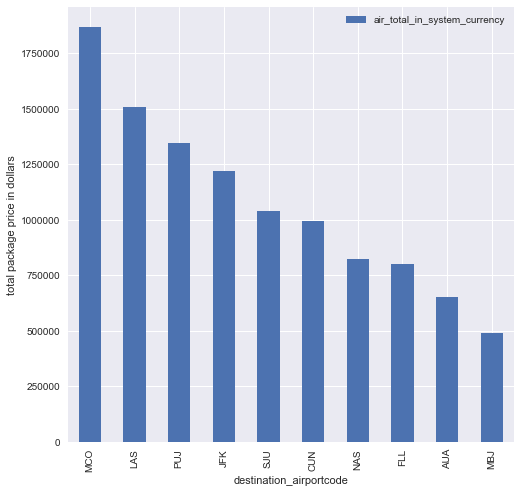

In [15]:
cash_df.head(10).plot(kind = 'bar', figsize = (8,8)).set_ylabel('total package price in dollars')

In [16]:
points_df = sum_df[['package_price_in_points']].\
    sort_values(by='package_price_in_points', ascending = False)

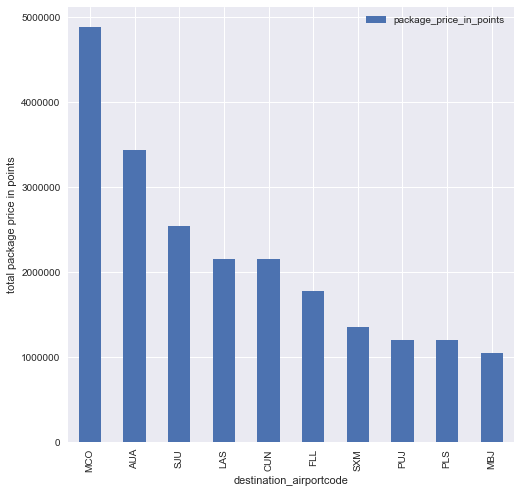

In [17]:
points_df.head(10).plot(kind='bar', figsize = (8,8)).set_ylabel('total package price in points')

Orlando and Las Vegas generate the most dollars for this particular client. However, Las Vegas drops to rank 4 in points. Question - Is there a relation between points and the Las Vegas destination?

In [18]:
sum_df_manyadults = df[(df['adults'] > 10)].\
    groupby('destination_airportcode').\
    sum().\
    sort_values(by ='adults', ascending = False).\
    head(10)
sum_df_manychildren = df[(df['total_children'] > 0)].\
    groupby('destination_airportcode').\
    sum().\
    sort_values(by ='total_children', ascending = False).\
    head(10)

In [19]:
manyadults = sum_df_manyadults[['adults']].sort_values(by = 'adults', ascending = False)
manychildren = sum_df_manychildren[['total_children']].sort_values(by = 'total_children', ascending = False)


frames = [manyadults, manychildren]
result = pd.concat(frames, axis = 1, join = 'outer').sort_values(by='adults', ascending=False)
result

adults  total_children
LAS  1317.0             NaN
NAS  1095.0           194.0
JFK   937.0           157.0
MCO   463.0          1151.0
PUJ   461.0           183.0
SJU   448.0           243.0
LGB   354.0           133.0
BGI   338.0             NaN
MBJ   256.0           131.0
CUN   241.0           180.0
AUA     NaN            99.0
FLL     NaN           175.0

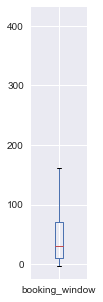

In [20]:
df[['booking_window']].plot(kind = 'box', figsize = (1,5))

In [21]:
df_mcolasonly

entered_date travel_begin_date travel_end_date   country_name  \
16      12/2/2015 14:42         12/3/2015       12/3/2015  United States   
34        7/8/2015 9:10         2/15/2016       2/22/2016  United States   
37      11/24/2015 7:58         12/3/2015       12/7/2015  United States   
41      7/17/2015 11:14         7/23/2015       7/26/2015  United States   
42      12/2/2015 17:05         12/3/2015       12/6/2015  United States   
45       7/22/2015 0:20          8/8/2015       8/13/2015  United States   
50     12/14/2015 10:26        12/15/2015      12/15/2015  United States   
104    12/29/2015 12:21         2/18/2016       2/22/2016  United States   
110      7/23/2015 8:16        10/14/2015      10/19/2015  United States   
112     7/11/2015 17:29         7/18/2015       7/25/2015  United States   
...                 ...               ...             ...            ...   
12363   1/12/2015 15:17         1/19/2015       1/21/2015  United States   
12368     4/1/2015 9:31          5/7/2015       5/11/2015  United States   
12409   1/23/2015 18:40         7/30/2015        8/3/2015  United States   
12442   4/28/2015 11:57         6/20/2015       6/22/2015  United States   
12467    6/29/2011 6:24          7/7/2011       7/12/2011       Tanzania   
12474   12/21/2016 7:52         3/14/2017       3/21/2017  United States   
12477  11/10/2010 16:43         1/30/2011        2/3/2011         Canada   
12493  11/13/2014 19:53         1/21/2015       1/27/2015      Argentina   
12550   4/27/2015 23:30          5/9/2015       5/13/2015  United States   
12566   11/8/2016 10:24        11/19/2016      11/24/2016  United States   

      cancelled cancelled_date loyalty departure_airportcode  \
16            f            NaN   False                   JFK   
34            f            NaN   False                   PVD   
37            f            NaN   False                   BDL   
41            f            NaN   False                   BOS   
42            f            NaN   False                   BOS   
45            f            NaN   False                   JFK   
50            f            NaN   False                   JFK   
104           f            NaN   False                   BOS   
110           f            NaN   False                   SJU   
112           f            NaN   False                   LGA   
...         ...            ...     ...                   ...   
12363         f            NaN   False                   JFK   
12368         f            NaN   False                   JFK   
12409         f            NaN   False                   JFK   
12442         f            NaN   False                   LGB   
12467         f            NaN   False                   BOS   
12474         f            NaN    True                   JFK   
12477         f            NaN   False                   BOS   
12493         f            NaN   False                   FLL   
12550         f            NaN   False                   BOS   
12566         f            NaN   False                   JFK   

      destination_airportcode  package_price_in_points    ...     \
16                        MCO                        0    ...      
34                        MCO                        0    ...      
37                        MCO                        0    ...      
41                        MCO                        0    ...      
42                        MCO                        0    ...      
45                        MCO                        0    ...      
50                        MCO                        0    ...      
104                       MCO                        0    ...      
110                       MCO                        0    ...      
112                       MCO                        0    ...      
...                       ...                      ...    ...      
12363                     LAS                        0    ...      
12368                     LAS                

In [22]:
df.corr()

loyalty  package_price_in_points  \
loyalty                            1.000000                 0.508105   
package_price_in_points            0.508105                 1.000000   
air_total_in_system_currency      -0.095300                -0.060279   
discount_total_in_system_currency -0.002131                -0.039464   
adults                            -0.123659                -0.069598   
children                          -0.069011                -0.033547   
infants_in_seat                    0.003959                -0.007613   
infants_in_lap                    -0.031418                -0.023313   
total_children                    -0.071944                -0.037603   
total_passengers                  -0.134926                -0.075310   
booking_window                     0.032974                 0.052771   
Dest_LAS                           0.018044                -0.020177   
Dest_MCO                          -0.012800                 0.019443   

                                   air_total_in_system_currency  \
loyalty                                               -0.095300   
package_price_in_points                               -0.060279   
air_total_in_system_currency                           1.000000   
discount_total_in_system_currency                     -0.002055   
adults                                                 0.759540   
children                                               0.204175   
infants_in_seat                                        0.003972   
infants_in_lap                                         0.031230   
total_children                                         0.196943   
total_passengers                                       0.775390   
booking_window                                         0.189738   
Dest_LAS                                               0.001441   
Dest_MCO                                              -0.016037   

                                   discount_total_in_system_currency  \
loyalty                                                    -0.002131   
package_price_in_points                                    -0.039464   
air_total_in_system_currency                               -0.002055   
discount_total_in_system_currency                           1.000000   
adults                                                     -0.030135   
children                                                    0.054684   
infants_in_seat                                            -0.006192   
infants_in_lap                                              0.037257   
total_children                                              0.060199   
total_passengers                                           -0.015950   
booking_window                                              0.010935   
Dest_LAS                                                    0.016971   
Dest_MCO                                                    0.005997   

                                     adults  children  infants_in_seat  \
loyalty                           -0.123659 -0.069011         0.003959   
package_price_in_points           -0.069598 -0.033547        -0.007613   
air_total_in_system_currency       0.759540  0.204175         0.003972   
discount_total_in_system_currency -0.030135  0.054684        -0.006192   
adults                             1.000000  0.051564        -0.008721   
children                           0.051564  1.000000         0.004811   
infants_in_seat                   -0.008721  0.004811         1.000000   
infants_in_lap                     0.023836  0.148145        -0.006369   
total_children                     0.053576  0.962575         0.050925   
total_passengers                   0.976061  0.259385         0.002682   
booking_window                     0.178285  0.046838         0.011223   
Dest_LAS                           0.048503 -0.108301        -0.011283   
Dest_MCO                           0.008325  0.236516         0.014421   

                                   infants

Las Vegas is correlated to number of adults (4.8%), booking window (3.4%), and number of total passengers (2.2%).

Orland is strongly correlated to number of children (23.5%), number of passengers (5.9%), and package price in points (1.9%)

---

## Modeling Insight

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import make_classification
from sklearn.grid_search import GridSearchCV

from sklearn import tree, ensemble, metrics, model_selection, externals

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

/Users/eunicelau/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/eunicelau/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [24]:
names_X_mco = [#'loyalty',
              #'package_price_in_points'
              #,'air_total_in_system_currency'
              #,'discount_total_in_system_currency'
              'adults'
              ,'children'
              ,'infants_in_seat'
              ,'infants_in_lap'
              ,'total_children'
              ,'total_passengers'
              ,'booking_window'
                ]
train_X_mco = df_mcolasonly[names_X_mco]
train_c_mco = df_mcolasonly.Dest_MCO

In [25]:
train_X_mco, train_c_mco = make_classification(n_samples=1000,
                                               n_features=10,
                                               n_informative=3,
                                               n_redundant=0,
                                               n_repeated=0,
                                               n_classes=2,
                                               random_state=0,
                                               shuffle=False)

In [26]:
rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True)

In [27]:
param_grid = { 
    'n_estimators': [100,200,300,400,500,600,700,800,900,1000],
    'max_features': [3, 4, 5, 6]
}

In [28]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(train_X_mco, train_c_mco)
print CV_rfc.best_params_

{'max_features': 6, 'n_estimators': 200}


In [29]:
model = ensemble.RandomForestClassifier(n_estimators = 1000,
        max_features = 5,
        min_samples_leaf = 5,
        oob_score = True,
        random_state = 0).\
    fit(train_X_mco, train_c_mco)
model.oob_score_

0.92300000000000004

In [30]:
test_X_mco = df_mcolasonly_test[names_X_mco]
test_c_mco = df_mcolasonly_test.Dest_MCO

In [31]:
model_test = ensemble.RandomForestClassifier(n_estimators = 200,
        max_features = 5,
        min_samples_leaf = 5,
        oob_score = True,
        random_state = 0).\
    fit(test_X_mco, test_c_mco)
model_test.oob_score_

0.90322580645161288

In [38]:
sorted(zip(model_test.feature_importances_, test_X_mco.columns.values), reverse = True)

[(0.66377541915141702, 'booking_window'),
 (0.24390601907826401, 'total_passengers'),
 (0.071820389468628093, 'adults'),
 (0.010633341890782421, 'total_children'),
 (0.0091919254864208638, 'children'),
 (0.00067290492448725204, 'infants_in_lap'),
 (0.0, 'infants_in_seat')]

In [37]:
df_mcolasonly_test['Prediction']= model_test.predict(test_X_mco)
test = df_mcolasonly_test[['Dest_MCO', 'Prediction']]
test.sum(axis=0)

Dest_MCO      166
Prediction    180
dtype: int64

---

## Conclusion

In order to make try out a Random Forest Classification, I removed all rows that were either Las Vegas or Orlando. This was done to see if there is a relationship between the selected columns and destination. 

The OOB is fairly high for this model, approximately 0.923. And the top predictive features used in this model is the booking window, total number of passengers, and adults. These were the top three metrics that was highly correlated to Las Vegas.

---

## Next Steps

To move this project forward, I would continue to see if there are other metrics that could improve the predictability power of the model. Though the OOB is around 0.9, there is still room for improvement and I believe it could go up even more, especially if I were to continue this modeling with more than two destinations.

I would also test for clustering to see if that would show specific types of people more obviously.

Since the training data is historical and the test data is more recent, there could be a change in purchasing behavior. This changes the analysis a bit since there's a time component to the data. I would possibly also dive into a time series model, predicting volume of a destination over time.